# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [67]:
#Name
ModelName = 'titanic_segmentation_model'

#Setting the VarId and VarDate parameters
VarId = 'PassengerId'
VarDate = 'ReferenceDate'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1


#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#It is necessary to define the types of variables (cageroric and numeric) to ensure that the type of data used in the modeling will be the most suitable.
#For example, categorical variables need to be defined as a string because this prevents it from being treated as a numeric variable in H20 modeling
#Another example is that the string variables will have a missing treatment by placing the missing category for all values found as 'null'
CAT = ['Pclass'
,'Embarked'
,'cabine_prefix'
,'NameTitle'
,'Sex']

#float
NUM = ['Fare'
,'SibSp'
,'Parch'
,'Age_Mean']
selected_features = CAT + NUM

# 2. Import Libraries

In [68]:
# !pip -q install -r requirements.txt

In [69]:
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import altair as alt
import glob
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
from io import StringIO
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [70]:
dataprep_df_full = pd.read_csv('./titanic/dataprep_df.csv')

In [71]:
dataprep_df_full

,Pclass,Embarked,cabine_prefix,Ticket_str,NameTitle,Sex,Fare,SibSp,Parch,Age_Mean,...,dummy_NameTitle_Mlle,dummy_NameTitle_Mr,dummy_NameTitle_Mrs,dummy_NameTitle_Ms,dummy_NameTitle_Sir,dummy_Sex_male,normalized_Fare,normalized_SibSp,normalized_Parch,normalized_Age_Mean
0,3,S,missing,A,Mr,male,7.2500,1.0,0.0,22.000000,...,0,1,0,0,0,1,0.029290,0.2,0.000000,0.293286
1,1,C,C,PC,Mrs,female,71.2833,1.0,0.0,38.000000,...,0,0,1,0,0,0,0.287989,0.2,0.000000,0.510737
2,1,S,C,missing,Mrs,female,53.1000,1.0,0.0,35.000000,...,0,0,1,0,0,0,0.214527,0.2,0.000000,0.469965
3,3,S,missing,missing,Mr,male,8.0500,0.0,0.0,35.000000,...,0,1,0,0,0,1,0.032523,0.0,0.000000,0.469965
4,3,Q,missing,missing,Mr,male,8.4583,0.0,0.0,29.699118,...,0,1,0,0,0,1,0.034172,0.0,0.000000,0.397922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,2,S,missing,missing,LOW,male,13.0000,0.0,0.0,27.000000,...,0,0,0,0,0,1,0.052521,0.0,0.000000,0.361239
848,1,S,B,missing,Miss,female,30.0000,0.0,0.0,19.000000,...,0,0,0,0,0,0,0.121202,0.0,0.000000,0.252514
849,3,S,missing,WC,Miss,female,23.4500,1.0,2.0,29.699118,...,0,0,0,0,0,0,0.094740,0.2,0.333333,0.397922
850,1,C,C,missing,Mr,male,30.0000,0.0,0.0,26.000000,...,0,1,0,0,0,1,0.121202,0.0,0.000000,0.347649


In [72]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [73]:
#List all dummies and normalized variables
normalized_and_dummy = []
for i in dataprep_df.columns:
    if (i.startswith('dummy_')) or (i.startswith('normalized_')):
        normalized_and_dummy.append(i)
# normalized_and_dummy

In [74]:
#Numeric features must be float type
for col_name in (NUM + normalized_and_dummy):
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

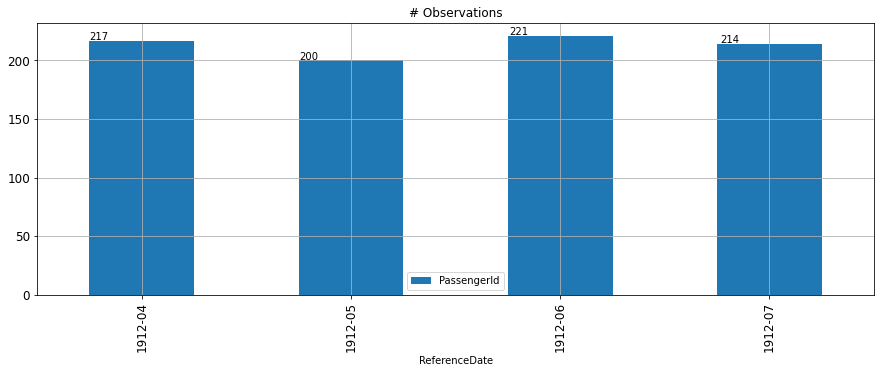

In [75]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId]].groupby(VarDate).agg({VarId:'count'})
ax = dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations"))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## 3.1 Treatment of Numeric Missing Data

In [76]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [77]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [78]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: ' 
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
#       + " | " 
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

## Number of Clusters

In [149]:
from sklearn.cluster import KMeans
km_scores= []
for i in range(2, dataprep_df[normalized_and_dummy].shape[1]):
    km = KMeans(n_clusters=i, random_state=1).fit(dataprep_df[normalized_and_dummy])
    km_scores.append(km.inertia_)

In [150]:
df_cluster_plot = pd.DataFrame({'number_of_clusters':[i for i in range(2,dataprep_df[normalized_and_dummy].shape[1])],'inertia': km_scores})

In [151]:
df_cluster_plot['lag_inertia'] = df_cluster_plot['inertia'].shift(1)
df_cluster_plot['pct_error_reduction'] = 1-(df_cluster_plot['inertia'] / df_cluster_plot['lag_inertia'])
# df_cluster_plot

In [152]:
max_number_of_clusters = df_plot.query('inc < 0.04')['number_of_clusters'].min()
max_number_of_clusters

10

In [153]:
elbow = alt.Chart(df_cluster_plot).mark_line(point=True).encode(
    x=alt.X('number_of_clusters:N', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('inertia'),
    tooltip=[alt.Tooltip('inertia', format='.2f')]
).properties(
    title='Inertia for number of cluster'
).properties(
    title='The elbow method'    
)

v_line = alt.Chart(pd.DataFrame({'max_number_of_clusters' : [max_number_of_clusters]})).mark_rule(color='red').encode(
    x='max_number_of_clusters:N'
)

(elbow + v_line).properties(width=800)

alt.LayerChart(...)

# 4. Modeling

## 4.1 Traning Models with H2O AutoML

## 4.1.1 Creating context and H2O and Importing data into the H2O context

In [155]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,5 hours 40 mins
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,5 months and 27 days !!!
H2O_cluster_name:,H2O_from_python_maxde_5kcaqm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.905 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [156]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.loc[:, (selected_features + normalized_and_dummy)])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in (NUM + normalized_and_dummy):
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 770
Validation: 82


## 4.2.2 Train the H2O Champion algorithm with new data

In [159]:
## This is the champion previous trained algorithms that will be used as comparison for the new experiments
vModel='H2O_KMeans_'

#Execution time of the model
start = dt.datetime.now()

from h2o.estimators import H2OKMeansEstimator
kmeans = H2OKMeansEstimator(k=max_number_of_clusters,
                             estimate_k=True,
                             standardize=False,
                             seed=1,
                             init='PlusPlus')

# The use of a validation_frame is recommended
kmeans.train(x=normalized_and_dummy,
             training_frame=train_hdf,
             validation_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")
print(kmeans)

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%

Execution time: 0:00:06.132708

Model Details
H2OKMeansEstimator :  K-means
Model Key:  KMeans_model_python_1669144138890_54


Model Summary: 


,,number_of_rows,number_of_clusters,number_of_categorical_columns,number_of_iterations,within_cluster_sum_of_squares,total_sum_of_squares,between_cluster_sum_of_squares
0,,770.0,6.0,0.0,28.0,1015.429772,1835.00096,819.571188




ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 1015.4297728147635
Total Sum of Square Error to Grand Mean: 1835.000961326196
Between Cluster Sum of Square Error: 819.5711885114324

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,119.0,238.852651
1,,2.0,139.0,177.123069
2,,3.0,297.0,247.215342
3,,4.0,51.0,133.211564
4,,5.0,36.0,62.020802
5,,6.0,128.0,157.006344



ModelMetricsClustering: kmeans
** Reported on validation data. **

Total Within Cluster Sum of Square Error: 118.67086099005249
Total Sum of Square Error to Grand Mean: 192.44646120232954
Between Cluster Sum of Square Error: 73.77560021227706

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,12.0,24.344892
1,,2.0,20.0,31.992169
2,,3.0,29.0,21.909929
3,,4.0,5.0,16.347148
4,,5.0,3.0,5.307662
5,,6.0,13.0,18.769061



Scoring History: 


,,timestamp,duration,iterations,number_of_clusters,number_of_reassigned_observations,within_cluster_sum_of_squares
0,,2022-11-22 21:54:31,0.000 sec,0.0,0.0,NaN,NaN
1,,2022-11-22 21:54:31,0.000 sec,1.0,1.0,770.0,3638.819773
2,,2022-11-22 21:54:31,0.015 sec,2.0,1.0,0.0,1835.000960
3,,2022-11-22 21:54:31,0.015 sec,3.0,2.0,0.0,1627.725735
4,,2022-11-22 21:54:31,0.015 sec,4.0,3.0,16.0,1355.179042
5,,2022-11-22 21:54:31,0.015 sec,5.0,3.0,1.0,1352.661232
6,,2022-11-22 21:54:31,0.015 sec,6.0,3.0,1.0,1352.629183
7,,2022-11-22 21:54:31,0.015 sec,7.0,3.0,0.0,1352.600238
8,,2022-11-22 21:54:31,0.015 sec,8.0,4.0,1.0,1345.446103
9,,2022-11-22 21:54:31,0.015 sec,9.0,4.0,6.0,1341.640347



See the whole table with table.as_data_frame()



In [160]:
perf = kmeans.model_performance()
perf


ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 1015.4297728147635
Total Sum of Square Error to Grand Mean: 1835.000961326196
Between Cluster Sum of Square Error: 819.5711885114324

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,119.0,238.852651
1,,2.0,139.0,177.123069
2,,3.0,297.0,247.215342
3,,4.0,51.0,133.211564
4,,5.0,36.0,62.020802
5,,6.0,128.0,157.006344


In [59]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

In [60]:
h2o.save_model(model=kmeans, path='%s/models/candidates/' % OutputPath, force=True)

'D:\\OneDrive\\FIEP\\FIEP-Machine-Learning-e-Computacao-em-Nuvem\\clusters_segmentation\\output_model\\models\\candidates\\KMeans_model_python_1669144138890_5'

# 5. Exporting the best model to Deploy (Usar o path_model_mojo para o código 3_Explaining_Model.ipynb)

In [61]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, kmeans.model_id))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    print(e)

path_model_mojo: D:\OneDrive\FIEP\FIEP-Machine-Learning-e-Computacao-em-Nuvem\clusters_segmentation\output_model\models\best\KMeans_model_python_1669144138890_5.zip


In [62]:
#Confusion Matrix for the Champion
df_cluster_tmp = h2o.mojo_predict_pandas(dataprep_df.loc[:, (normalized_and_dummy)], mojo_zip_path=path_model_mojo, verbose=False)

df_cluster = pd.concat([df_cluster_tmp.reset_index(drop=True), dataprep_df.loc[:, (normalized_and_dummy+selected_features)].reset_index(drop=True)], axis=1)
# df_cluster['cluster'] = df_cluster['cluster'] + 1
df_cluster['cluster'] = df_cluster['cluster'].astype(int)

df_cluster

,cluster,dummy_Pclass_2,dummy_Pclass_3,dummy_Embarked_Missing,dummy_Embarked_Q,dummy_Embarked_S,dummy_cabine_prefix_B,dummy_cabine_prefix_C,dummy_cabine_prefix_D,dummy_cabine_prefix_E,...,normalized_Age_Mean,Pclass,Embarked,cabine_prefix,NameTitle,Sex,Fare,SibSp,Parch,Age_Mean
0,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.293286,3,S,missing,Mr,male,7.2500,1.0,0.0,22.000000
1,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.510737,1,C,C,Mrs,female,71.2833,1.0,0.0,38.000000
2,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.469965,1,S,C,Mrs,female,53.1000,1.0,0.0,35.000000
3,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.469965,3,S,missing,Mr,male,8.0500,0.0,0.0,35.000000
4,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.397922,3,Q,missing,Mr,male,8.4583,0.0,0.0,29.699118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.361239,2,S,missing,LOW,male,13.0000,0.0,0.0,27.000000
848,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.252514,1,S,B,Miss,female,30.0000,0.0,0.0,19.000000
849,5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.397922,3,S,missing,Miss,female,23.4500,1.0,2.0,29.699118
850,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.347649,1,C,C,Mr,male,30.0000,0.0,0.0,26.000000


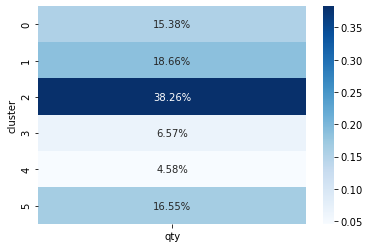

In [66]:
df_cluster_plot = df_cluster.reset_index().groupby(['cluster']).count()[['index']].rename(columns={'index': 'qty'})
# sns.heatmap(df_cluster_plot, annot=True, center=True,cmap='Blues', fmt='g')
# plt.show()
sns.heatmap(df_cluster_plot/np.sum(df_cluster_plot), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

# 6. Save final dataset with predictions to CSV to explain the model

In [64]:
df_cluster.to_csv('./titanic/df_cluster.csv', index=False, header=True)